In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

%matplotlib inline

Using TensorFlow backend.


In [2]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add( Dense(16, activation = 'relu', input_dim = 9) )
        #self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'hard_sigmoid') )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img):
        self.preds = self.model.predict(test_img).reshape(4,4)
        self.preds_binary = self.preds.copy()
        self.preds_binary[self.preds_binary < 0.5] = 0
        self.preds_binary[self.preds_binary >= 0.5] = 1
        self.bayes_image = np.empty(16)
        self.index_when_given_q = np.all(self.q_matrix == test_img, axis = 1)
        self.p_given_q = self.p_matrix[self.index_when_given_q]
        for i in range(16):
            is_one_counter = 0
            target_list = [self.p_given_q[j][i] for j in range(self.p_given_q.shape[0])]
            total_length = len(target_list)
    
            for j in range(total_length):
                if target_list[j] == 1:
                    is_one_counter += 1
            prob = is_one_counter / total_length
            self.bayes_image[i] = prob
        print(self.preds, self.preds_binary, self.bayes_image)
        self.fig, self.axes = plt.subplots(nrows = 1, ncols = 4, figsize = (14,14))
        self.axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        self.axes[0].set_title("original image")
        self.axes[1].imshow(self.preds, cmap = plt.cm.binary)
        self.axes[1].set_title("predicted image")
        self.axes[2].imshow(self.preds_binary, cmap = plt.cm.binary)
        self.axes[2].set_title("predicted image with binalization")
        self.axes[3].imshow(self.bayes_image.reshape(4,4), cmap = plt.cm.binary)
        self.axes[3].set_title("p(P|Q) image based on bayes")
        

In [3]:
autoencoder = AE(optimizer = "rmsprop", loss = keras.losses.binary_crossentropy)

## モデル

In [4]:
autoencoder.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
Total params: 432
Trainable params: 432
Non-trainable params: 0
_________________________________________________________________


## 学習

In [5]:
autoencoder.fit(epochs = 5, batch_size=256)

Train on 983040 samples, validate on 983040 samples
Epoch 1/5
983040/983040 [==============================] - 13s 13us/step - loss: 0.5666 - acc: 0.0351 - val_loss: 0.5551 - val_acc: 0.0334
Epoch 2/5
983040/983040 [==============================] - 12s 13us/step - loss: 0.5544 - acc: 0.0423 - val_loss: 0.5538 - val_acc: 0.0385
Epoch 3/5
983040/983040 [==============================] - 13s 13us/step - loss: 0.5538 - acc: 0.0442 - val_loss: 0.5527 - val_acc: 0.0389
Epoch 4/5
983040/983040 [==============================] - 14s 14us/step - loss: 0.5526 - acc: 0.0462 - val_loss: 0.5530 - val_acc: 0.0538
Epoch 5/5
983040/983040 [==============================] - 12s 12us/step - loss: 0.5521 - acc: 0.0448 - val_loss: 0.5508 - val_acc: 0.0452


## 予測

[[0.271422   0.4736831  0.8156098  0.66229415]
 [0.         0.4828418  0.9276455  0.32900143]
 [0.4599232  0.5517624  0.12217906 0.07598343]
 [0.8026904  0.48990482 0.13666639 0.41188717]] [[0. 0. 1. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] [0.2654321  0.39969136 0.85339506 0.6867284  0.06018519 0.42283951
 0.92592593 0.16820988 0.25154321 0.74845679 0.05092593 0.13117284
 0.85802469 0.3117284  0.13580247 0.41049383]


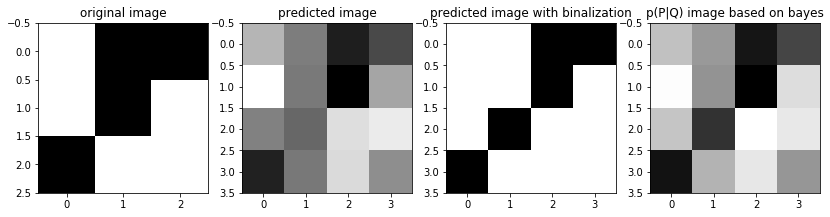

In [6]:
test_img = np.array([[0,1,1,0,1,0,1,0,0]])
autoencoder.predict(test_img)

## ベイズルールによる結果

In [7]:
index_when_given_q = np.all(autoencoder.q_matrix == test_img, axis = 1)
p_given_q = autoencoder.p_matrix[index_when_given_q]

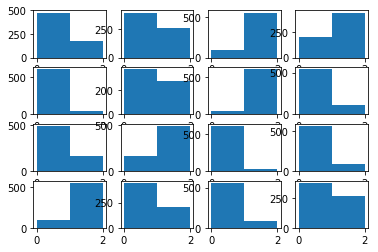

In [8]:
n = 16
for i in range(n):
    ax = plt.subplot(4, 4, i+1)
    plt.hist([p_given_q[j][i] for j in range(p_given_q.shape[0])], bins = [0,1,2])

In [9]:
n = 16
bayes_image = np.empty(n)
for i in range(n):
    is_one_counter = 0
    target_list = [p_given_q[j][i] for j in range(p_given_q.shape[0])]
    total_length = len(target_list)
    
    for j in range(total_length):
        if target_list[j] == 1:
            is_one_counter += 1
    prob = is_one_counter / total_length
    bayes_image[i] = prob

In [10]:
bayes_image

array([0.2654321 , 0.39969136, 0.85339506, 0.6867284 , 0.06018519,
       0.42283951, 0.92592593, 0.16820988, 0.25154321, 0.74845679,
       0.05092593, 0.13117284, 0.85802469, 0.3117284 , 0.13580247,
       0.41049383])

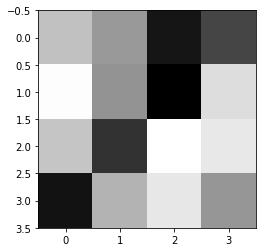

In [11]:
plt.imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)